In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime

In [2]:
today = datetime.date.today().isoformat()
today

'2020-10-22'

In [3]:
states = [
  "Baden-Wuerttemberg",
  "Bayern",
  "Berlin",
  "Brandenburg",
  "Bremen",
  "Germany",
  "Hamburg",
  "Hessen",
  "Mecklenburg-Vorpommern",
  "Niedersachsen",
  "Nordrhein-Westfalen",
  "Rheinland-Pfalz",
  "Saarland",
  "Sachsen-Anhalt",
  "Sachsen",
  "Schleswig-Holstein",
  "Thueringen"
]

In [4]:
# Nowcasting

def preproc_nowcasting(fname):
    raw_data = pd.read_excel(fname, sheet_name="Nowcast_R");
    cols = {
        'Datum des Erkrankungsbeginns': 'date',
        'Punktschätzer der Reproduktionszahl R': 'r', 
        'Untere Grenze des 95%-Prädiktionsintervalls der Reproduktionszahl R': 'rmin',
        'Obere Grenze des 95%-Prädiktionsintervalls der Reproduktionszahl R': 'rmax'
    }
    return raw_data[cols.keys()].rename(columns=cols)

In [5]:
# SECIR
# "we obtain a distribution of Rt values for each date. The results of simulations are given in different columns in the CSV files."
# https://gitlab.com/simm/covid19/secir

# ymin=Quant.025, ymax=Quant.975
def preproc_secir(fname):
    raw_data = pd.read_csv(fname)
    values_only = raw_data[raw_data.columns.difference(['date'])]
    values_only.quantile(axis=1,q=0.975)

    data = pd.DataFrame({
        'date': pd.to_datetime(raw_data["date"]),
        'rmin': values_only.quantile(axis=1, q=0.025),
        'rmax': values_only.quantile(axis=1, q=0.975),
        'r': values_only.quantile(axis=1, q=0.5),
    })
    data = data[data['date'] >= pd.to_datetime('2020-03-06')]
    return data

In [11]:
methods = {
    'secir': {
        "name": 'Helmholtz SECIR',
        "pre": preproc_secir,
        "files": [{
            "fname": f"data/SECIR_{state}_{today}.csv",
            "key": state,
            "url": f"https://gitlab.com/simm/covid19/secir/-/raw/master/img/dynamic/Rt_rawData/{state}_Rt.csv?inline=false",
        } for state in states]
    },
    'nowcasting': {
        "name": 'RKI Nowcasting',
        "pre": preproc_nowcasting,
        "files": [{
            "fname": f"data/Nowcasting_{today}.xlsx",
            "key": "Germany",
            "url": "https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Projekte_RKI/Nowcasting_Zahlen.xlsx?__blob=publicationFile",
        }]
    },
}

In [12]:
for _, m_config in methods.items():
    print(f"getting data for {m_config['name']}")
    for e in m_config["files"]:
        fname = e["fname"]
        url = e["url"]
        print(f"getting {fname}")
        !wget -q "{url}" -O {fname}

getting data for Helmholtz SECIR
getting data/SECIR_Baden-Wuerttemberg_2020-10-22.csv
getting data/SECIR_Bayern_2020-10-22.csv
getting data/SECIR_Berlin_2020-10-22.csv
getting data/SECIR_Brandenburg_2020-10-22.csv
getting data/SECIR_Bremen_2020-10-22.csv
getting data/SECIR_Germany_2020-10-22.csv
getting data/SECIR_Hamburg_2020-10-22.csv
getting data/SECIR_Hessen_2020-10-22.csv
getting data/SECIR_Mecklenburg-Vorpommern_2020-10-22.csv
getting data/SECIR_Niedersachsen_2020-10-22.csv
getting data/SECIR_Nordrhein-Westfalen_2020-10-22.csv
getting data/SECIR_Rheinland-Pfalz_2020-10-22.csv
getting data/SECIR_Saarland_2020-10-22.csv
getting data/SECIR_Sachsen-Anhalt_2020-10-22.csv
getting data/SECIR_Sachsen_2020-10-22.csv
getting data/SECIR_Schleswig-Holstein_2020-10-22.csv
getting data/SECIR_Thueringen_2020-10-22.csv
getting data for RKI Nowcasting
getting data/Nowcasting_2020-10-22.xlsx


In [13]:
do_states = False
if do_states:
    ignored_states = ["Hamburg", "Berlin", "Bremen"]

    #ignored_states = ["Baden-Wuerttemberg", "Bayern"]
    data = {(method["name"]+": "+file["key"]): method["pre"](file["fname"])
        for _, method in methods.items() for file in method["files"] if file["key"] not in ignored_states}
else:
    data = {(method["name"]): method["pre"](file["fname"])
        for _, method in methods.items() for file in method["files"] if file["key"] == "Germany"}

In [14]:
#data

In [15]:
measures=[
    ('2020-03-10', 'Major events cancelled'),
    ('2020-03-12', 'Merkel calls for avoiding social contacts'),
    ('2020-03-16', 'Shops, schools and day-care centres closed,\nReligious services prohibited, entry ban'),
]

antimeasures=[
    ('2020-04-20',"First relaxation of measures"),
    ('2020-05-06', "Partial reopening of shops, schools, playgrounds")
]

In [16]:
to_date = pd.to_datetime

In [17]:
last = {k: d.to_dict(orient="records")[-1] for k, d in data.items()}

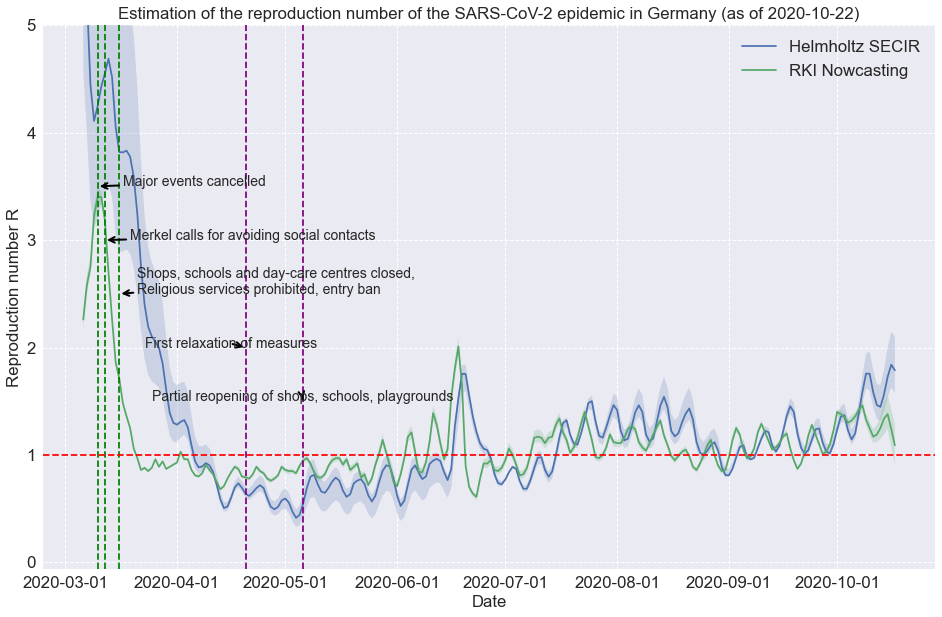

In [18]:
matplotlib.style.use('seaborn')
s = 1.5
fs = 'large'
params = {'font.size' : 14,
          'legend.fontsize': fs,
          'figure.figsize': (8*s,5.5*s),
          'axes.labelsize': fs,
          'axes.titlesize':fs,
          'xtick.labelsize':fs,
          'ytick.labelsize':fs,
          'axes.formatter.use_locale': True}
plt.rcParams.update(params)

arrowprops = {'arrowstyle': '->','lw':2}

fig = plt.figure(figsize=(16, 10))
plt.title(f"Estimation of the reproduction number of the SARS-CoV-2 epidemic in Germany (as of {today})")
#plt.figtext(0.9, 0.01, 'Sources: ' + ', '.join(sources.values()), horizontalalignment='right')
plt.xlabel("Date")
plt.ylabel("Reproduction number R")
for name, d in data.items():
    plt.plot(d["date"],d["r"],label=f"{name}")
    plt.fill_between(d["date"], d["rmin"], d["rmax"], alpha=0.2,label=f"_{name}: 95% confidence interval")

#fig.autofmt_xdate()
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m-%d"))
ax.set_ylim(top=5)

for m in measures:
    plt.axvline(to_date(m[0]),ls='--',c='green')
    
for m in antimeasures:
    plt.axvline(to_date(m[0]),ls='--',c='purple')
    
for idx, (date, txt) in enumerate(measures+antimeasures):
    y=3.5-idx*0.5
    x=to_date(date)
    plt.annotate(txt,(x,y),xytext=(to_date('2020-03-17') + pd.Timedelta(days=2 * idx),y),arrowprops=arrowprops)

for name, d in last.items():
    if not "Germany" in name: continue
    date = d['date'].isoformat()[:10]
    last_text = f"{name}\nNewest value: {d['r']:.2f}\n(95%: {d['rmin']:.2f} - {d['rmax']:.2f})\n({date})"
    last_xy = (d['date'],d['r'])
    last_xytext = (d['date']-pd.Timedelta(days=4),-1) if name != 'nowcasting' else (d['date']-pd.Timedelta(days=2),2)
    plt.annotate(last_text,last_xy,last_xytext,arrowprops=arrowprops,ha='center')

plt.axhline(1,c='red',ls='--')
plt.grid(ls='--')
plt.legend()
today_plotfile = f"plots/plot_{today}.png"
plt.savefig(today_plotfile,dpi=100)

In [19]:
with open("README.md") as f:
    newreadme = "".join((f"![{today_plotfile}]({today_plotfile})" if line.startswith("!") else line) for line in f)
with open("README.md", "w") as f:
    f.write(newreadme)